In [52]:
import arff
import pandas as pd
import numpy as np
import re
import requests
import tldextract
from urllib.parse import urlparse
from bs4 import BeautifulSoup
import whois
from datetime import datetime
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    RocCurveDisplay,
)
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns



In [53]:
with open('phishing+websites/Training Dataset.arff', 'r') as f:
    arff_data = arff.load(f)
df = pd.DataFrame(arff_data['data'], columns=[attr[0] for attr in arff_data['attributes']])

# Clean and prepare
df = df.replace('?', np.nan).fillna(0)
for col in df.columns:
    if col != 'Result':
        df[col] = pd.to_numeric(df[col], errors='coerce')
df['Result'] = pd.to_numeric(df['Result'], errors='coerce').replace(-1, 0)
df = df[df['Result'].isin([0, 1])]

X = df.drop(columns=['Result'])
y = df['Result']
feature_columns = X.columns.tolist()


C:\Users\zalha\AppData\Local\Temp\ipykernel_21008\186460241.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="pastel")


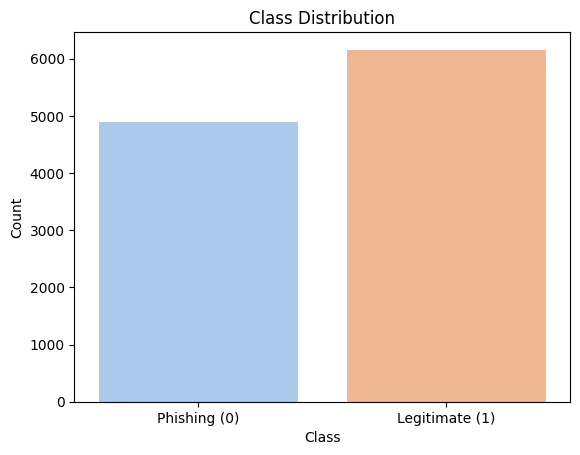

In [54]:
# Plot class distribution
plt.figure()
sns.countplot(x=y, palette="pastel")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(ticks=[0, 1], labels=["Phishing (0)", "Legitimate (1)"])
plt.show()

In [55]:
def get_whois_info(domain):
    try:
        print(f"Querying WHOIS for domain: {domain}")
        w = whois.whois(domain)
        creation = w.creation_date
        expiration = w.expiration_date
        if isinstance(creation, list): creation = creation[0]
        if isinstance(expiration, list): expiration = expiration[0]
        now = datetime.now()
        age = (now - creation).days if creation else 0
        reg_length = (expiration - creation).days if creation and expiration else 0
        return age, reg_length
    except Exception as e:
        print(f"WHOIS query failed for domain {domain}: {e}")
        return 0, 0


In [56]:
def extract_arff_features(url, expected_columns):
    features = {}
    def has_ip(url): return 1 if re.match(r"^(http[s]?://)?\d+\.\d+\.\d+\.\d+", url) else 0
    def shortening_service(url): return 1 if re.search(r"(bit\.ly|goo\.gl|tinyurl|ow\.ly|t\.co|x\.co)", url) else 0
    def has_at_symbol(url): return 1 if '@' in url else 0
    def double_slash_redirect(url): return 1 if url.rfind('//') > 6 else 0
    def prefix_suffix(domain): return 1 if '-' in domain else 0
    def sub_domain_count(url):
        hostname = urlparse(url).hostname or ''
        return 2 if hostname.count('.') > 2 else (1 if hostname.count('.') == 2 else 0)
    def ssl_state(url): return 1 if url.startswith("https") else 0
    def favicon_check(domain, soup):
        icons = soup.find_all("link", rel=lambda x: x and 'icon' in x.lower())
        for icon in icons:
            href = icon.get("href", "")
            if domain not in href: return 1
        return 0

    try:
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=10)
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
    except:
        html = ""
        soup = BeautifulSoup("", 'html.parser')

    parsed = urlparse(url)
    ext = tldextract.extract(url)
    domain = parsed.netloc
    full_domain = ext.domain + "." + ext.suffix

    age, reg_length = get_whois_info(full_domain)

    features['having_IP_Address'] = has_ip(url)
    features['URL_Length'] = len(url)
    features['Shortining_Service'] = shortening_service(url)
    features['having_At_Symbol'] = has_at_symbol(url)
    features['double_slash_redirecting'] = double_slash_redirect(url)
    features['Prefix_Suffix'] = prefix_suffix(full_domain)
    features['having_Sub_Domain'] = sub_domain_count(url)
    features['SSLfinal_State'] = ssl_state(url)
    features['Domain_registeration_length'] = reg_length
    features['Favicon'] = favicon_check(domain, soup)
    features['port'] = 0
    features['HTTPS_token'] = 1 if 'https' in domain.lower() else 0

    imgs = soup.find_all('img', src=True)
    total_imgs = len(imgs)
    external_imgs = len([img for img in imgs if ext.domain not in img['src']])
    features['Request_URL'] = 1 if total_imgs > 0 and external_imgs / total_imgs >= 0.5 else 0

    anchors = soup.find_all('a', href=True)
    total_anchors = len(anchors)
    null_anchors = len([a for a in anchors if a['href'] in ['#', 'javascript:void(0);', ''] or ext.domain not in a['href']])
    features['URL_of_Anchor'] = 1 if total_anchors > 0 and null_anchors / total_anchors > 0.5 else 0

    tags = soup.find_all(['link', 'script', 'meta'], href=True)
    external_tags = len([tag for tag in tags if ext.domain not in tag.get('href', '')])
    features['Links_in_tags'] = 1 if external_tags > 2 else 0

    forms = soup.find_all('form', action=True)
    suspicious_forms = len([form for form in forms if form['action'] == "" or ext.domain not in form['action']])
    features['SFH'] = 1 if len(forms) > 0 and suspicious_forms / len(forms) >= 0.5 else 0

    features['Submitting_to_email'] = 1 if re.search(r"mailto:", html.lower()) else 0
    features['Abnormal_URL'] = 1 if domain not in url else 0
    features['Redirect'] = 1 if soup.find('meta', attrs={'http-equiv': re.compile("refresh", re.I)}) or re.search(r"window\.location|location\.replace", html.lower()) else 0
    features['on_mouseover'] = 1 if re.search(r"onmouseover\s*=", html.lower()) else 0
    features['RightClick'] = 1 if re.search(r"event.button\s*==\s*2", html.lower()) else 0
    features['popUpWidnow'] = 1 if re.search(r"alert\s*\(", html.lower()) else 0
    features['Iframe'] = 1 if "<iframe" in html.lower() else 0

    features['age_of_domain'] = age
    features['DNSRecord'] = 1
    features['web_traffic'] = 0
    features['Page_Rank'] = 0
    features['Google_Index'] = 1 if "google" in html.lower() else 0
    features['Links_pointing_to_page'] = len(anchors)
    features['Statistical_report'] = 0

    for col in expected_columns:
        if col not in features:
            features[col] = 0

    return pd.DataFrame([[features[col] for col in expected_columns]], columns=expected_columns)


In [57]:
# # 🐟 Updated list of known phishing URLs
# phish_urls = [
#     "http://toncoinsp.com",
#     "http://www.paypa1.com",
#     "http://www.faceb00k-login.com",
#     "http://www.apple-support-security-alert.com",
#     "http://www.bankofamerica-login.com",
#     "http://www.g00gle-login-attempt.com",
#     "http://paypal-opladen.be",
#     "http://login.microsoftonline.ccisystems.us",
#     "http://login-amazon-account.com",
#     "http://apple-grx-support-online.com",
#     "http://renew-netflix.com",
#     "http://allegrolokalnie.pl-1751.cfd",
#     "http://mondiai-rps.com/index.php"
# ]

# # Extract features and label them as phishing (Result = 0)
# new_phish_samples = []
# for url in phish_urls:
#     try:
#         feat = extract_arff_features(url, feature_columns)
#         feat["Result"] = 0
#         new_phish_samples.append(feat)
#     except Exception as e:
#         print(f"❌ Failed to process {url}: {e}")

# # Add new phishing samples to the existing dataset
# if new_phish_samples:
#     df_phish = pd.concat(new_phish_samples, ignore_index=True)
#     df = pd.concat([df, df_phish], ignore_index=True)

# # ✅ Rebuild feature and label sets
# X = df.drop(columns=['Result'])
# y = df['Result']


In [58]:
# 🔁 Retrain the XGBoost model with updated data
model = lgb.LGBMClassifier()

In [ ]:
# Split your dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Retrain on training split (optional but recommended for realistic evaluation)
model.fit(X_train, y_train)

# Predict on test split
y_pred = model.predict(X_test)

# Evaluate
print("📈 Model Evaluation Metrics:\n")
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n🧮 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred, target_names=["Phishing (0)", "Legitimate (1)"]))


[LightGBM] [Info] Number of positive: 4926, number of negative: 3918
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3
[LightGBM] [Info] Number of data points in the train set: 8844, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556988 -> initscore=0.228946
[LightGBM] [Info] Start training from score 0.228946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [60]:
# test_url = input("🔍 Enter a URL to check: ").strip()

# def is_valid_url(url):
#     parsed = urlparse(url)
#     return bool(parsed.scheme) and bool(parsed.netloc)

# if is_valid_url(test_url):
#     try:
#         features_df = extract_arff_features(test_url, feature_columns)
#         print("\n✅ Extracted Features:")
#         print(features_df.T)

#         proba = model.predict_proba(features_df)[0][1]
#         print(f"\n🎯 Phishing Probability: {proba:.4f}")

#         if proba > 0.85:
#             print("✅ Legitimate (High confidence)")
#         elif proba > 0.5:
#             print("⚠️ Suspicious – Further analysis recommended")
#         else:
#             print("❌ Phishing (High confidence)")

#     except Exception as e:
#         print("❌ Error processing URL:", e)
# else:
#     print("⚠ Invalid URL format. Please include http:// or https://")


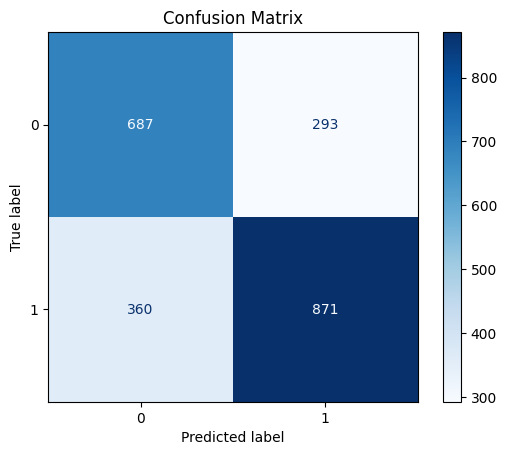

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

           0       0.66      0.70      0.68       980
           1       0.75      0.71      0.73      1231

    accuracy                           0.70      2211
   macro avg       0.70      0.70      0.70      2211
weighted avg       0.71      0.70      0.71      2211



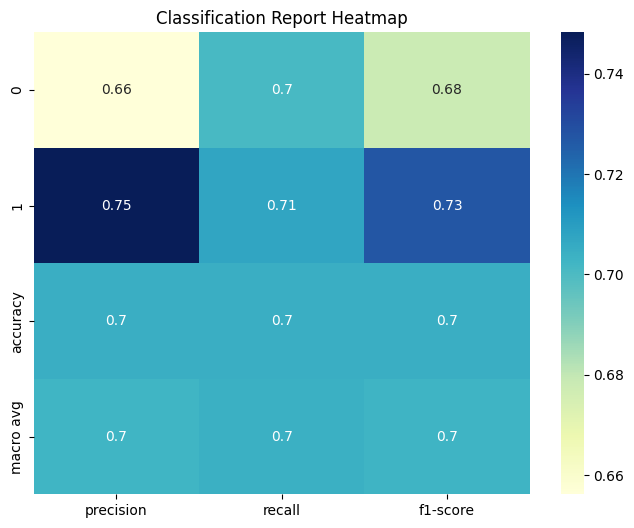

In [62]:
print(classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(df.iloc[:-1, :-1], annot=True, cmap="YlGnBu")
plt.title("Classification Report Heatmap")
plt.show()

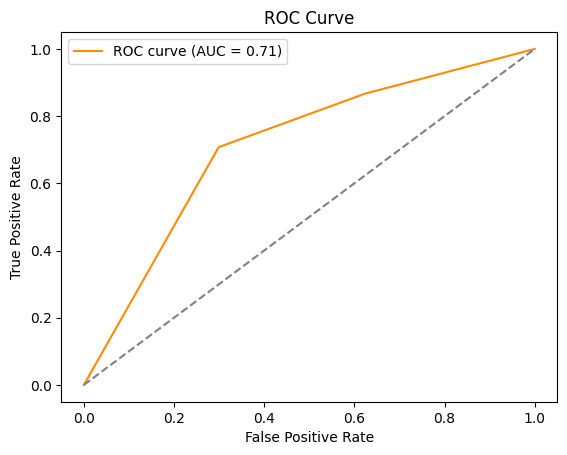

In [63]:
# For binary classification
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [64]:
# feature_importances = pd.DataFrame({
#     'Feature': ['Links_in_tags'],
#     'Importance': [model.feature_importances_[0]]
# })

# # Plot the feature importance
# plt.figure(figsize=(6, 4))
# plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.title("Feature Importance")
# plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
# plt.show()

[LightGBM] [Info] Number of positive: 500, number of negative: 384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 884, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.565611 -> initscore=0.263966
[LightGBM] [Info] Start training from score 0.263966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

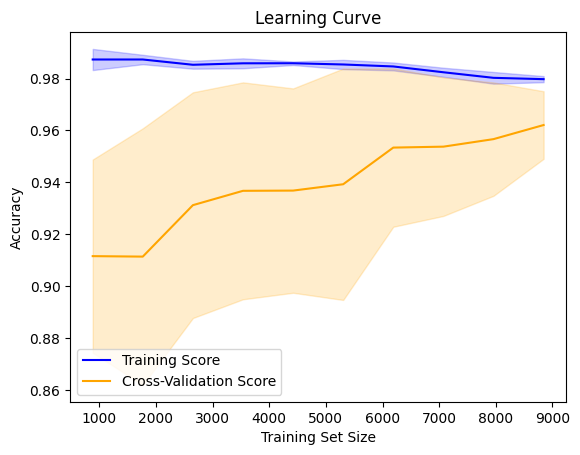

In [65]:
# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation
train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
test_mean, test_std = test_scores.mean(axis=1), test_scores.std(axis=1)

# Plot learning curve
plt.figure()
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.plot(train_sizes, test_mean, label="Cross-Validation Score", color="orange")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="orange", alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()
